In [1]:
%matplotlib inline

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

# some default imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# we will use arviz for some of the plotting
import arviz as az

# import jax and set it up to use double precision
from jax import config
config.update("jax_enable_x64", True)

import numpyro
numpyro.set_host_device_count(4)
numpyro.set_platform('cpu')

from jax import numpy as jnp, random
from numpyro import sample, handlers
import numpyro.distributions as dist
from numpyro.distributions import (
    Categorical,
    Dirichlet,
    ImproperUniform,
    Normal,
    OrderedLogistic,
    TransformedDistribution,
    constraints,
    transforms,
)
from numpyro.infer import MCMC, NUTS
from numpyro.infer.reparam import TransformReparam

# set plotting context
sns.set_context('notebook')
sns.set_palette('colorblind')

# Gaussian regression

We are provided with a set of scores for each candidate, issued by a number of judges over different categories (Originality/Creativity, Importance to the Field, Clarity) with certain confidence. In this simplified model, we will imagine that each judge has actually reported a Gaussian PDF representing a measurement of the true score (plus some bias), with mean given by the reported score and variance inversely proportional to the confidence.

For a given category (say, Clarity), let the score reported for candidate $i$ by judge $j$ be $x_{ij}$ and the uncertainty $\sigma_{ij} \propto {\rm confidence}$. Then, the posterior for the true score $\mu$ of this candidate is, assuming the judges are independent,
$$
p(\mu_i \mid \{x_{ij}, \sigma_{ij} \}_j) = \prod_j p(\mu_i \mid x_{ij}, \sigma_{ij}) \propto \prod_j p(x_{ij} \mid \mu_i, \sigma_{ij}) \, p(\mu_i)
$$
By the Gaussian assumption, let's assume the score of an individual judge is drawn such that 
$$
p(x_{ij} \mid \mu_i, \sigma_{ij}) = \mathcal{N}(\mu_i, \sigma_{ij})[x_{ij}]
$$
Once we specify a prior for the true score $p(\mu_i)$ we are done with this simple model where there is no judge bias. A simple prior could be a uniform distribution, or a Gaussian with mean $\Mu$ and standard deviation $\Sigma$,
$$
p(\mu_i) = \mathcal{N}(\Mu, \Sigma)[\mu_i] \, .
$$

Now, we could also take a look at all candidates simultaneously and consider the possibility that the judges are biased by some amount $\beta_j$. Assume a prior on $\beta_j \sim \mathcal{N}(0, \Beta)$
$$
p(\mu_i \mid \{x_{ij}, \sigma_{ij} \}_{j}, \Beta) \propto \prod_j p(x_{ij} \mid \mu_i, \sigma_{ij}, \Beta) \, p(\mu_i)
$$

Load the ranking data.

In [3]:
# load anonimized data
data = pd.read_csv('ranking_data_anon.csv')
data.replace('x', np.nan, inplace=True)
data.replace('-', np.nan, inplace=True)
data.iloc[:5]

,Judge,Category,Candidate-0,Candidate-1,Candidate-2,Candidate-3,Candidate-4,Candidate-5,Candidate-6,Candidate-7,...,Candidate-28,Candidate-29,Candidate-30,Candidate-31,Candidate-32,Candidate-33,Candidate-34,Candidate-35,Candidate-36,Candidate-37
0,Judge-0,Orig/ Creat.,6,7,9,9,7,8,8,7,...,7,5,6,7,8,6,9,6,8,7
1,Judge-0,Imp. Field,6,8,9,9,8,7,7,7,...,6,7,6,8,8,7,9,6,8,8
2,Judge-0,Clarity,6,7,9,9,8,8,7,7,...,7,6,6,8,8,7,8,8,8,7
3,Judge-0,Confidence,3,3,1,1,1,2,2,3,...,1,3,3,2,1,3,1,3,2,3
4,Judge-1,Orig/ Creat.,6,7,9,8,7,6,7,6,...,6,7,6,8,8,6,8,6,7,6


In [4]:
candidates = [c for c in data.columns if 'Candidate' in c]
judges = data['Judge'].unique()
categories = [c for c in data['Category'].unique() if c != 'Confidence']

In [6]:
confidence = data[data['Category'] == 'Confidence'][candidates]
sigma = confidence.astype(float).values

x = np.array([g[candidates].values for k,g in data.groupby('Category') if k != 'Confidence'])
x = x.astype(float)

# patch missing scores with uninformative values
for xcat in x:
    missing = np.isnan(xcat) | np.isnan(sigma)
    xcat[missing] = 5
    sigma[missing] = 5

In [7]:
np.any(np.isnan(x))

False

In [8]:
x.shape, sigma.shape

((3, 9, 38), (9, 38))

In [9]:
n_categories, n_judges, n_candidates = x.shape

### Gausian model

We will model the above draws as taken from a categorical process with unknown cut points and measure the location of the cut points. We will start wih an improper uniform prior on the cut points; we will set the affinitiy to zero because it's fully degenerate with the location of the cut points in this case.

In [10]:
def model(x=None, sigma=sigma):
    n_categories, n_judges, n_candidates = x.shape
    mu = sample('mu', Normal(5, 5), sample_shape=(n_categories, 1, n_candidates,))
    beta = sample('beta', Normal(0, 2), sample_shape=(1,n_judges,1))
    x = sample('x', Normal(mu + beta, sigma), obs=x)

key = random.PRNGKey(1234)
mcmc_key, pred_key = random.split(key)
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=250, num_samples=750, num_chains=4)
mcmc.run(mcmc_key, x=x)

result = az.from_numpyro(mcmc)

# get posterior predictive
# predictive = numpyro.infer.Predictive(model, mcmc.get_samples())
# pred = predictive(pred_key)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

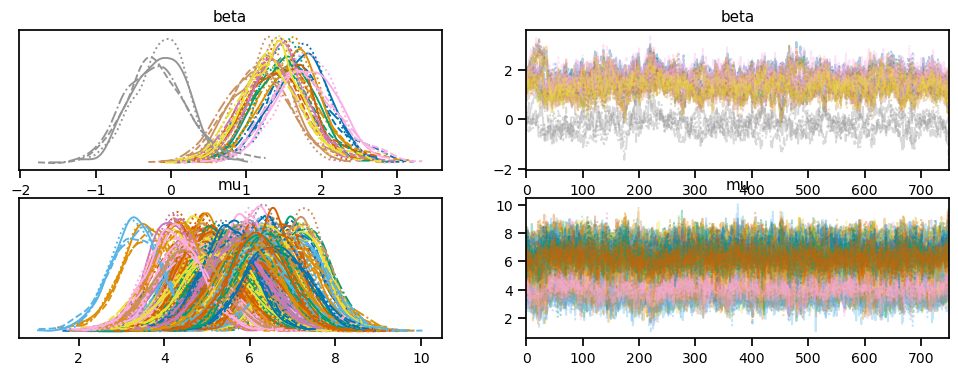

In [11]:
az.plot_trace(result);

In [12]:
samples = result.posterior.stack(sample=('chain', 'draw'))

In [13]:
samples.beta.shape

(1, 9, 1, 3000)

In [14]:
mu = samples.mu.values
mu = mu.reshape(n_categories, n_candidates, mu.shape[-1])

beta = samples.beta.values
beta = beta.reshape(n_judges, beta.shape[-1])

In [15]:
mu_df = pd.DataFrame()
for cat, mu_cat in zip(categories, mu):
    df = pd.DataFrame(mu_cat.T, columns=candidates)
    df['Category'] = cat
    mu_df = pd.concat([mu_df, df], ignore_index=True)

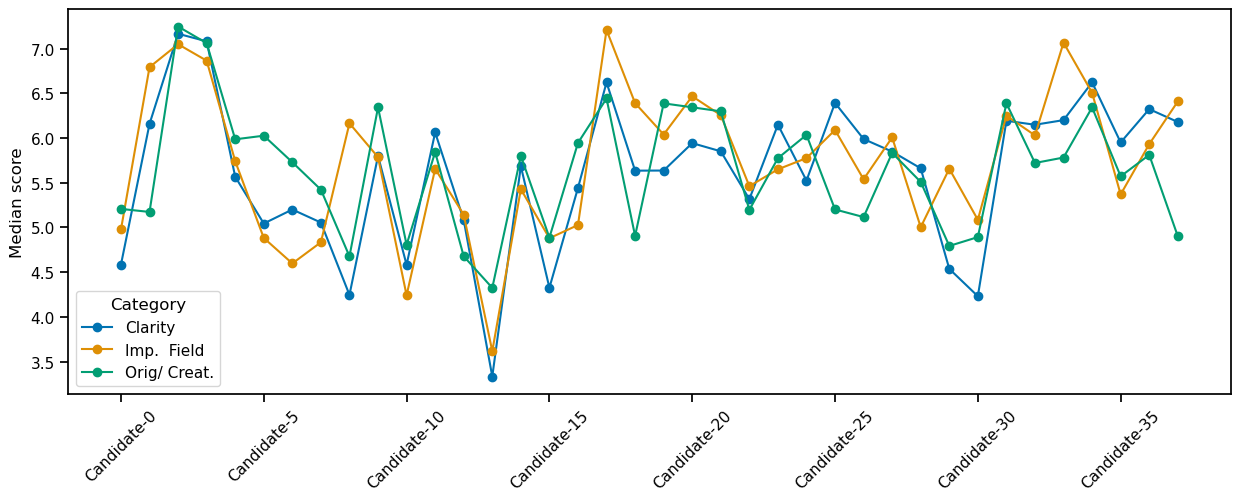

In [21]:
median_score = mu_df.groupby('Category').median()

median_score.T.plot(marker='o', figsize=(15, 5))
plt.ylabel('Median score')
plt.xticks(rotation=45);

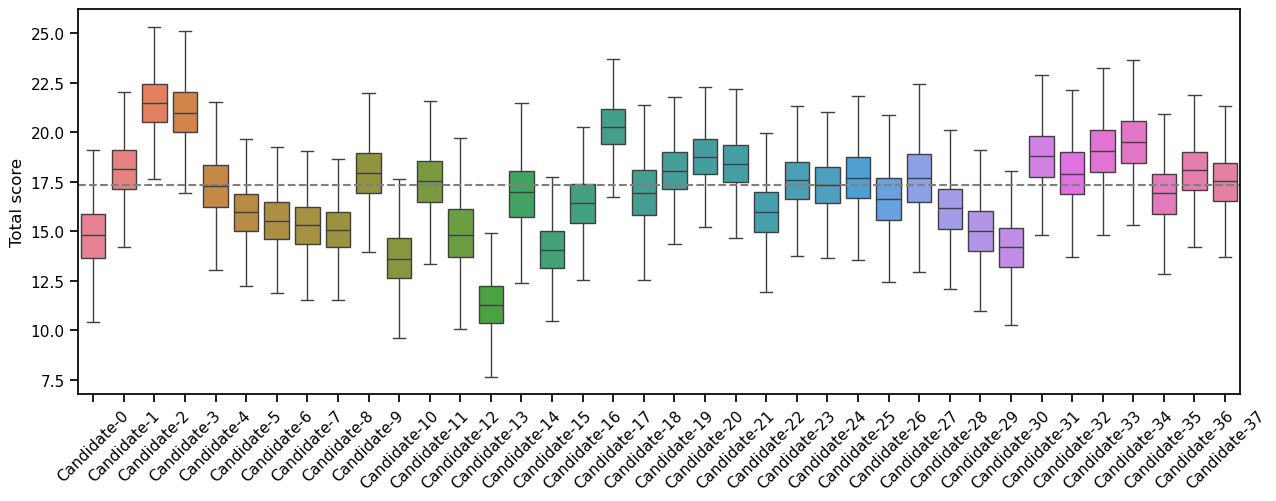

In [23]:
score_sum = np.sum(mu, axis=0)

df = pd.DataFrame(score_sum.T, columns=candidates)

median_total_score = df.median().median()

# boxplot without showing outliers
plt.figure(figsize=(15, 5))
sns.boxplot(df, showfliers=False)

plt.axhline(median_total_score, color='gray', linestyle='--')

plt.ylabel("Total score")

# tilt the x-axis labels
plt.xticks(rotation=45);

In [29]:
fraction_above_median = np.apply_along_axis(lambda y: len(y[y > median_total_score])/len(y), 1, score_sum)
sorted(zip(fraction_above_median, candidates), reverse=True)

[(0.9976666666666667, 'Candidate-2'),
 (0.9916666666666667, 'Candidate-3'),
 (0.979, 'Candidate-17'),
 (0.9186666666666666, 'Candidate-34'),
 (0.8626666666666667, 'Candidate-20'),
 (0.8613333333333333, 'Candidate-33'),
 (0.8363333333333334, 'Candidate-31'),
 (0.7783333333333333, 'Candidate-21'),
 (0.7126666666666667, 'Candidate-1'),
 (0.7073333333333334, 'Candidate-19'),
 (0.7056666666666667, 'Candidate-36'),
 (0.664, 'Candidate-9'),
 (0.645, 'Candidate-32'),
 (0.5953333333333334, 'Candidate-25'),
 (0.5796666666666667, 'Candidate-27'),
 (0.576, 'Candidate-23'),
 (0.5636666666666666, 'Candidate-11'),
 (0.5543333333333333, 'Candidate-37'),
 (0.5066666666666667, 'Candidate-24'),
 (0.49433333333333335, 'Candidate-4'),
 (0.4116666666666667, 'Candidate-14'),
 (0.411, 'Candidate-18'),
 (0.397, 'Candidate-35'),
 (0.33766666666666667, 'Candidate-26'),
 (0.26466666666666666, 'Candidate-16'),
 (0.215, 'Candidate-28'),
 (0.19266666666666668, 'Candidate-22'),
 (0.161, 'Candidate-5'),
 (0.1073333333

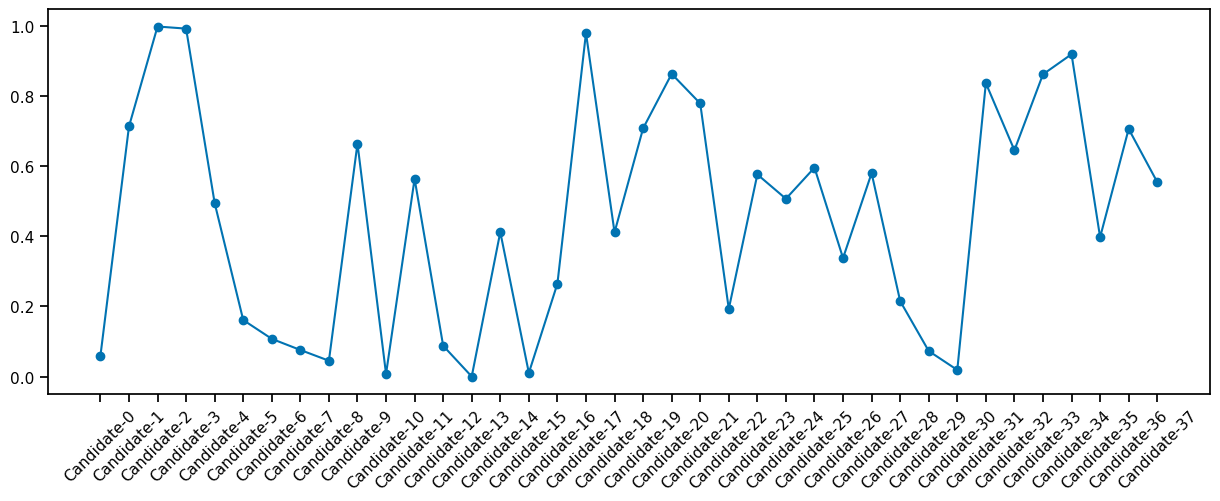

In [33]:
plt.figure(figsize=(15, 5))
plt.plot(candidates, fraction_above_median, 'o-')
plt.xticks(rotation=45);

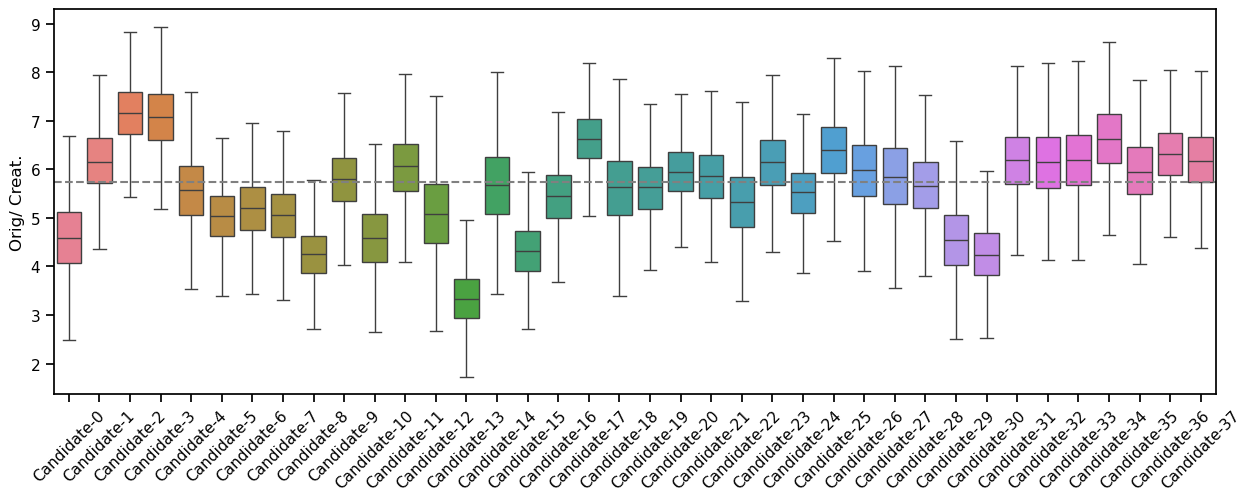

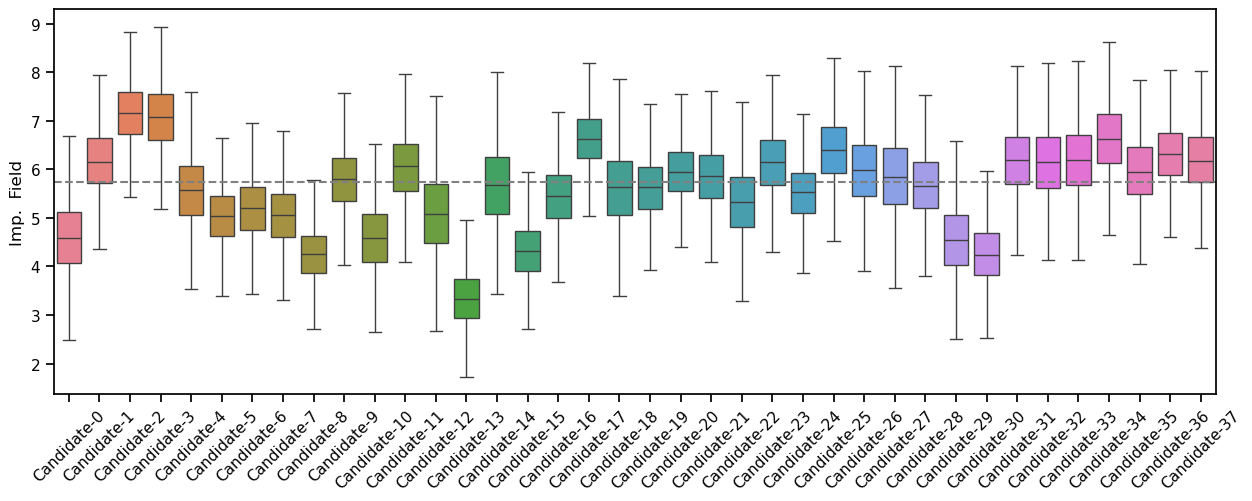

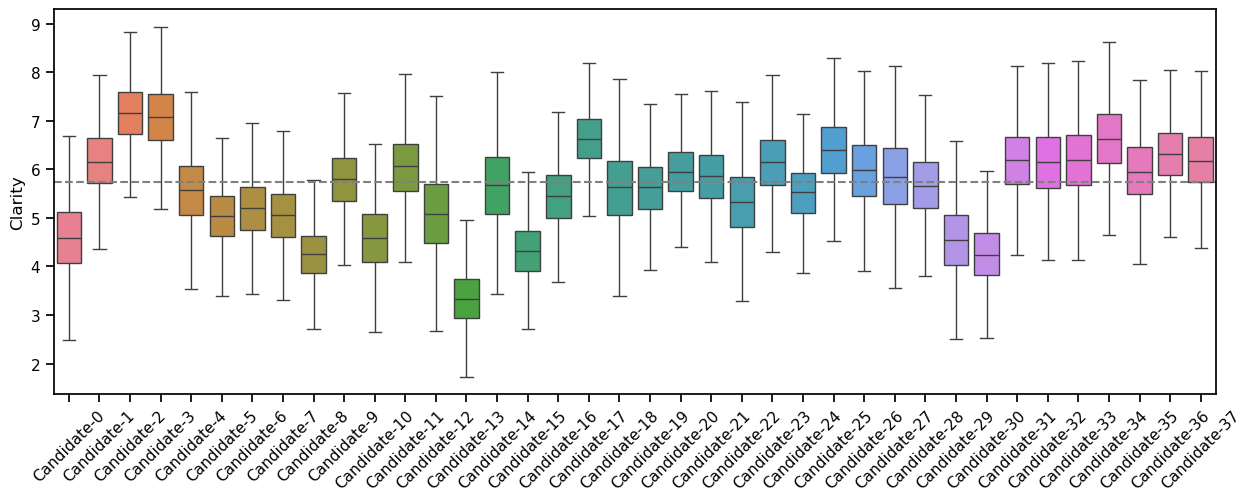

In [18]:
for cat, df in zip(categories, mu):
    
    df = pd.DataFrame(mu_cat.T, columns=candidates)

    m = df.median().median()

    # boxplot without showing outliers
    plt.figure(figsize=(15, 5))
    sns.boxplot(df, showfliers=False)

    plt.axhline(m, color='gray', linestyle='--')

    plt.ylabel(cat)

    # tilt the x-axis labels
    plt.xticks(rotation=45);

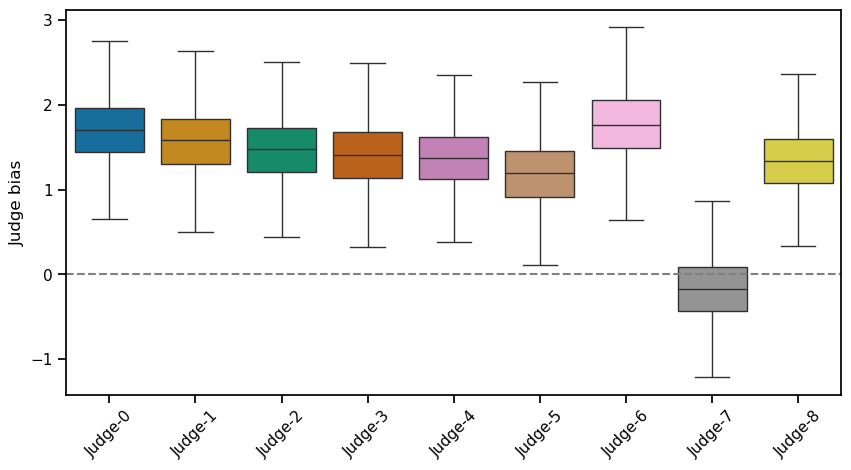

In [19]:
df = pd.DataFrame(beta.T, columns=judges)
# boxplot without showing outliers
plt.figure(figsize=(10, 5))
sns.boxplot(df, showfliers=False)
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel('Judge bias')
# tilt the x-axis labels
plt.xticks(rotation=45);